In [17]:
import mlflow
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import os

In [40]:
data_dir = "../data/raw"
output_dir = "../data/processed"

input_dev_path = f"{data_dir}/dataset_kobe_dev.parquet"
input_prod_path = f"{data_dir}/dataset_kobe_prod.parquet"

output_dev_path = f"{output_dir}/data_dev"
output_prod_path = f"{output_dir}/data_prod"
output_filtered_dev_path = f"{output_dir}/data_filtered_dev"
output_filtered_prod_path = f"{output_dir}/data_filtered_prod"
output_train_path = f"{output_dir}/base_train"
output_test_path = f"{output_dir}/base_test"

experiment_name = "PipelinePreparacaoDados"
mlflow_url = "sqlite:///mlruns.db"

columns = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']


In [3]:
mlflow.set_tracking_uri(mlflow_url)
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)

mlflow.set_experiment(experiment_name)
mlflow.start_run(run_name= experiment_name)

<ActiveRun: >

In [4]:
df_dev = pd.read_parquet(input_dev_path)
df_prod = pd.read_parquet(input_prod_path)
df_filtered_dev = df_dev[columns].dropna()
df_filtered_prod = df_prod[columns].dropna()

In [5]:
path = output_filtered_dev_path + '.parquet'
df_filtered_dev.to_parquet(path)
mlflow.log_artifact(path)

In [6]:
df_filtered_prod.to_parquet(output_filtered_prod_path + '.parquet')
mlflow.log_artifact(output_filtered_prod_path + '.parquet')
df_filtered_dev.to_csv(output_filtered_prod_path + '.csv')
mlflow.log_artifact(output_filtered_prod_path + '.csv')


In [7]:
df_filtered_prod.to_parquet(output_filtered_prod_path + '.parquet')
mlflow.log_artifact(output_filtered_prod_path + '.parquet')

In [8]:
df_filtered_dev.to_parquet(output_filtered_dev_path+'.parquet')
mlflow.log_artifact(output_filtered_dev_path+'.parquet')

In [9]:
random=42
test_size=0.2
df_train, df_test = train_test_split(df_filtered_dev, test_size=test_size, random_state=random, stratify=df_filtered_dev['shot_made_flag'])

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

array([[<Axes: xlabel='lat', ylabel='lat'>,
        <Axes: xlabel='lon', ylabel='lat'>,
        <Axes: xlabel='minutes_remaining', ylabel='lat'>,
        <Axes: xlabel='period', ylabel='lat'>,
        <Axes: xlabel='playoffs', ylabel='lat'>,
        <Axes: xlabel='shot_distance', ylabel='lat'>,
        <Axes: xlabel='shot_made_flag', ylabel='lat'>],
       [<Axes: xlabel='lat', ylabel='lon'>,
        <Axes: xlabel='lon', ylabel='lon'>,
        <Axes: xlabel='minutes_remaining', ylabel='lon'>,
        <Axes: xlabel='period', ylabel='lon'>,
        <Axes: xlabel='playoffs', ylabel='lon'>,
        <Axes: xlabel='shot_distance', ylabel='lon'>,
        <Axes: xlabel='shot_made_flag', ylabel='lon'>],
       [<Axes: xlabel='lat', ylabel='minutes_remaining'>,
        <Axes: xlabel='lon', ylabel='minutes_remaining'>,
        <Axes: xlabel='minutes_remaining', ylabel='minutes_remaining'>,
        <Axes: xlabel='period', ylabel='minutes_remaining'>,
        <Axes: xlabel='playoffs', ylabel='minut

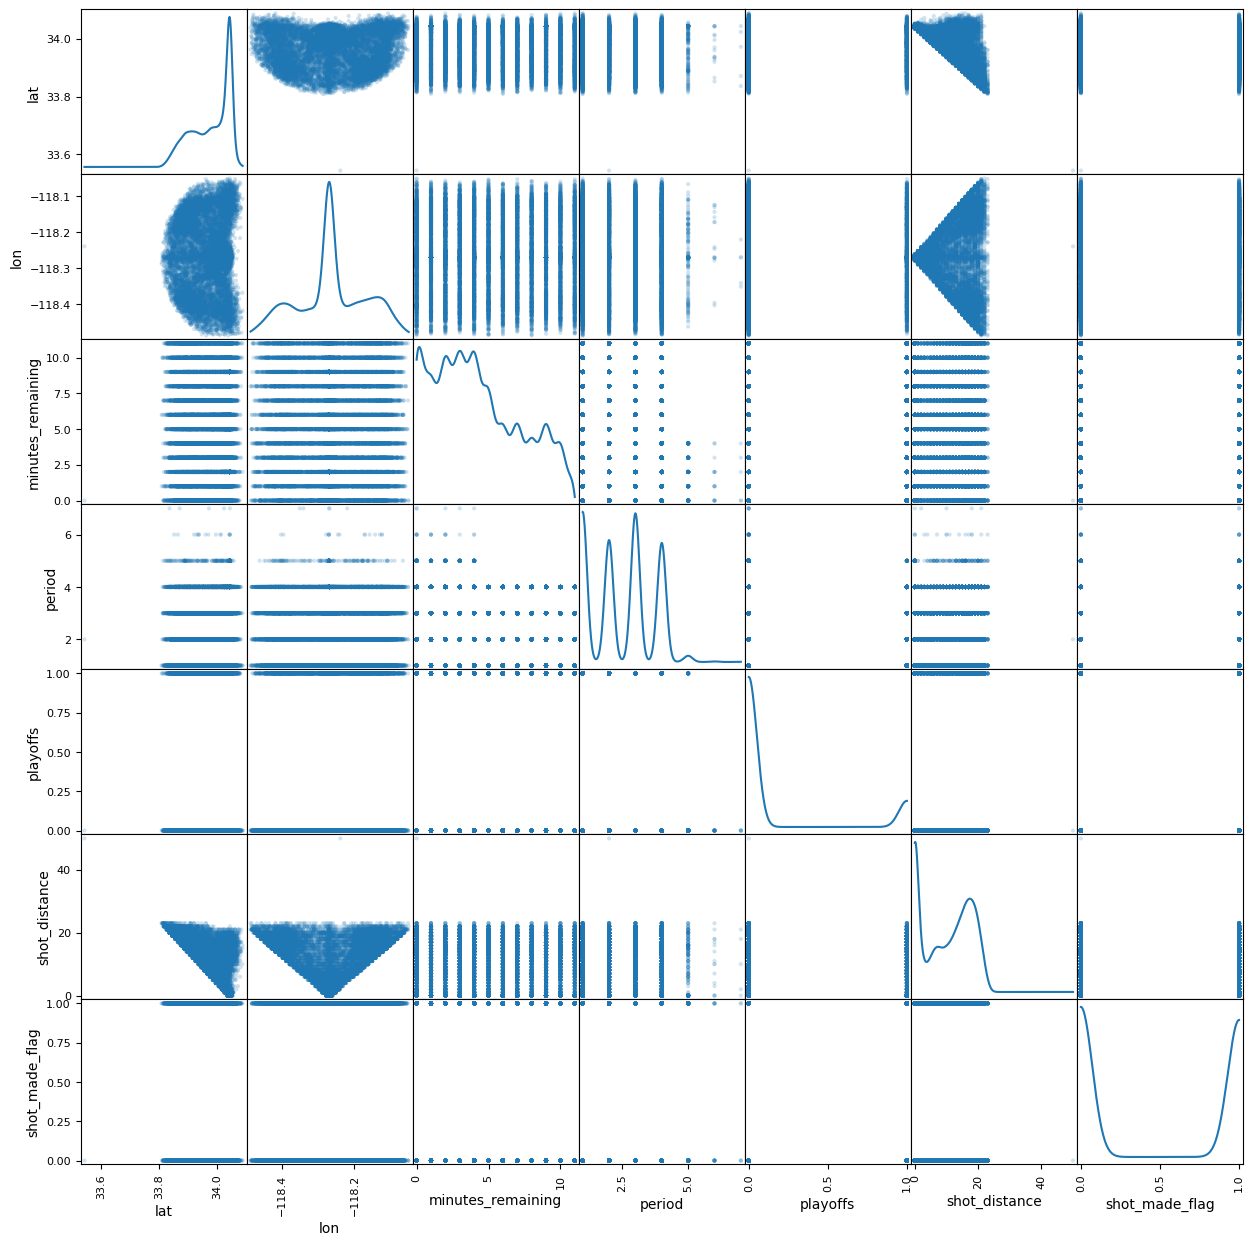

In [11]:
df_test.to_parquet(output_test_path + '.parquet')
mlflow.log_artifact(output_test_path + '.parquet')  
df_train.to_parquet(output_train_path + '.parquet')
mlflow.log_artifact(output_train_path + '.parquet')  

pd.plotting.scatter_matrix(df_train, diagonal='kde', figsize=(15,15), alpha=0.2)



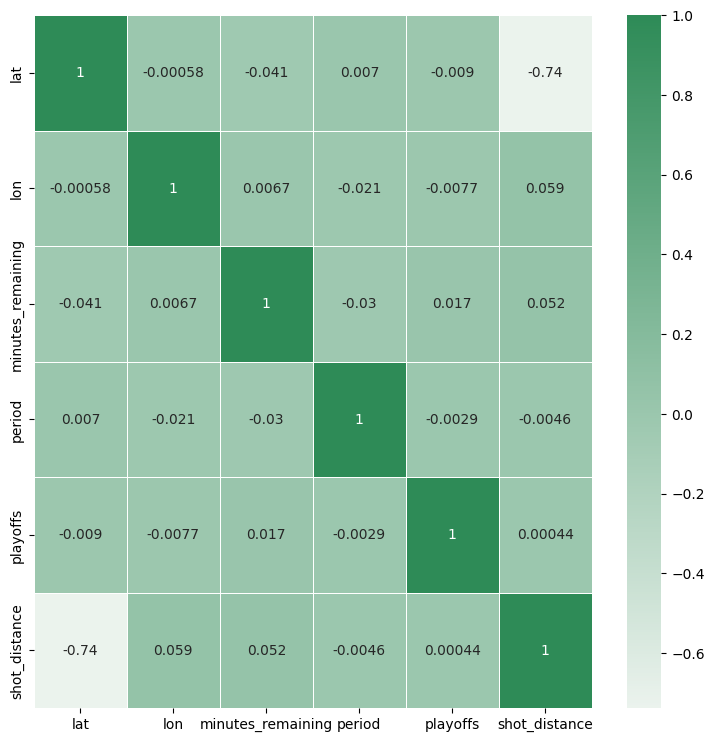

In [35]:
df_data = df_train.copy()
df_data.drop(['shot_made_flag'], axis=1, inplace=True)
df_wine_corr = df_data.corr()
plt.figure(figsize=(9, 9))
sns.heatmap(df_wine_corr, annot=True, linewidth=.5, cmap=sns.light_palette("seagreen", as_cmap=True))
plt.savefig(f"{output_dir}/base_train_matrix.png", bbox_inches='tight')


In [28]:
from sklearn.preprocessing import StandardScaler
def scaler_dataset(df, drop_columns):
    df_scaler = df.drop(drop_columns, axis=1)
    scale = StandardScaler()
    scaled = scale.fit_transform(df_scaler)
    df_scaler = pd.DataFrame(scaled, columns=df_scaler.columns, index=df.index)
    return df_scaler

In [32]:
df_train_scaler = scaler_dataset(df_train, ['shot_made_flag'])
df_train_scaler['shote_made_flag'] = df_train['shot_made_flag']

df_test_scaler = scaler_dataset(df_test, ['shot_made_flag'])
df_test_scaler['shot_made_flag'] = df_test['shot_made_flag']

df_test_scaler.to_parquet(f"{output_dir}/base_test_scaler.parquet")
df_train_scaler.to_parquet(f"{output_dir}/base_train_scaler.parquet")

In [38]:
for type in ['train', 'test']:
    file_path = f'{output_dir}/base_{type}.parquet'
    data = pd.read_parquet(file_path)
    numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.drop('shot_made_flag')

    for column in numerical_columns:
        plt.figure(figsize=(10,5))
        sns.histplot(data[data['shot_made_flag'] == 1][column], label='Arremessos convertidos (1)', kde=True, element='step', stat='density', common_norm=False)
        sns.histplot(data[data['shot_made_flag'] == 0][column], label='Arremeços errados (0)', kde=True, element='step', stat='density', common_norm=False)
        plt.legend()
        plt.title(f'Distribuição de {column} por Resultado do Arremesso ({type})')
        plt.xlabel(column)
        plt.ylabel('Densidade')
        plt.savefig(f'{output_dir}/{type}_hist_density_{column}.png', bbox_inches='tight')
        plt.close()

In [39]:
mlflow.end_run()